# Backtesting trading strategies using `zipline` with LKTB `bundles`

## Importing libraries

In [1]:
%load_ext watermark

In [2]:
%load_ext zipline

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # 그래프를 더 높은 해상도로 출력

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import zipline
from trading_calendars import get_calendar
# from yahoofinancials import YahooFinancials
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
%watermark --iversions

pandas  0.22.0
zipline v1.3.0
numpy   1.14.3



## Import custom data - LKTB futures

In [6]:
!zipline bundles

csvdir <no ingestions>
krx_futures 2020-03-25 08:08:04.871141
krx_futures 2020-03-25 05:23:40.981897
krx_futures 2020-03-25 05:22:42.884178
quandl 2020-02-14 02:32:04.287211
quandl 2020-02-14 02:30:18.481401
quandl 2020-02-14 02:29:44.742234
quandl 2020-02-14 02:29:22.007164
quandl 2020-02-14 02:27:14.838854
quandl 2020-02-13 04:26:16.333277
quandl 2020-02-13 04:18:29.688599
quantopian-quandl 2020-02-14 05:16:44.368675


`krx_futures` 라는 이름으로 custom bundle을 추가합니다. .zipline/extension.py 파일을 아래 코드와 같이 변경합니다.

In [ ]:
import pandas as pd

from zipline.data.bundles import register
from zipline.data.bundles.csvdir import csvdir_equities

start_session = pd.Timestamp('2012-01-02', tz='utc')
end_session = pd.Timestamp('2019-12-30', tz='utc')

# register the bundle
register(
    'krx_futures',  # name we select for the bundle
    csvdir_equities(
        # name of the directory as specified above (named after data frequency)
        ['daily'],
        # path to directory containing the
        './data',
    ),
    calendar_name='XKRX',  # Korea Exchange
    start_session=start_session,
    end_session=end_session

In [10]:
!zipline ingest --bundle krx_futures

Merging daily equity files:
Loading custom pricing data: 
 | ktb: sid 0
 | lktb: sid 1


In [11]:
!zipline bundles

csvdir <no ingestions>
krx_futures 2020-03-26 04:27:58.929015
krx_futures 2020-03-25 08:08:04.871141
krx_futures 2020-03-25 05:23:40.981897
krx_futures 2020-03-25 05:22:42.884178
quandl 2020-02-14 02:32:04.287211
quandl 2020-02-14 02:30:18.481401
quandl 2020-02-14 02:29:44.742234
quandl 2020-02-14 02:29:22.007164
quandl 2020-02-14 02:27:14.838854
quandl 2020-02-13 04:26:16.333277
quandl 2020-02-13 04:18:29.688599
quantopian-quandl 2020-02-14 05:16:44.368675


## Strategies

### Buy And Hold Strategy

In [6]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o buy_and_hold.pkl --trading-calendar XKRX

# imports
from zipline.api import order_percent, order, record, symbol, set_benchmark
from zipline.finance import commission

# parameters
SELECTED_STOCK = 'LKTB'
# n_stocks_to_buy = 10 # order_percent 로 변경하며 주석처리

def initialize(context):
    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_ordered = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))

def handle_data(context, data):
    
    # trading logic
    if not context.has_ordered:
        # placing order, negative number for sale/short
        order_percent(context.asset, 1)
        # setting up a flag for holding a position
        context.has_ordered = True
        
    # record price for further inspection
    record(price=data.current(context.asset, 'price'))

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2019-01-02 06:30:00+00:00,NaN,0.000000,NaN,0.000313,NaN,NaN,0.00000,10000.00000,0.000,0.000,...,0.0,0.0,0,NaN,10000.00000,0.000,0.000,1,[],0.0
2019-01-03 06:30:00+00:00,0.005588,-0.000498,-0.026416,-0.000861,0.016691,0.334785,-9960.89796,39.10204,9955.920,9955.920,...,0.0,0.0,0,-11.224972,10000.00000,0.000,0.000,2,"[{'price': 127.70382000000001, 'dt': 2019-01-0...",0.0
2019-01-04 06:30:00+00:00,0.004800,-0.001044,-0.045920,-0.001409,0.011852,0.352992,0.00000,39.10204,9950.460,9950.460,...,0.0,0.0,0,-12.947533,39.10204,9955.920,9955.920,3,[],0.0
2019-01-07 06:30:00+00:00,0.007619,-0.002214,-0.048828,-0.002583,0.011183,0.557167,0.00000,39.10204,9938.760,9938.760,...,0.0,0.0,0,-12.696364,39.10204,9950.460,9950.460,4,[],0.0
2019-01-08 06:30:00+00:00,0.008957,-0.003618,-0.043427,-0.003992,0.011108,0.690608,0.00000,39.10204,9924.720,9924.720,...,0.0,0.0,0,-13.025496,39.10204,9938.760,9938.760,5,[],0.0
2019-01-09 06:30:00+00:00,0.010793,-0.003228,-0.017156,-0.003601,0.012587,0.783027,0.00000,39.10204,9928.620,9928.620,...,0.0,0.0,0,-10.605768,39.10204,9924.720,9924.720,6,[],0.0
2019-01-10 06:30:00+00:00,0.016762,-0.001512,0.006100,-0.001879,0.018092,0.894791,0.00000,39.10204,9945.780,9945.780,...,0.0,0.0,0,-4.587192,39.10204,9928.620,9928.620,7,[],0.0
2019-01-11 06:30:00+00:00,0.018809,-0.003618,0.003087,-0.003992,0.019705,0.930602,0.00000,39.10204,9924.720,9924.720,...,0.0,0.0,0,-7.029800,39.10204,9945.780,9945.780,8,[],0.0
2019-01-14 06:30:00+00:00,0.024390,-0.000888,0.008623,-0.001252,0.025209,0.954637,0.00000,39.10204,9952.020,9952.020,...,0.0,0.0,0,-1.609417,39.10204,9924.720,9924.720,9,[],0.0
2019-01-15 06:30:00+00:00,0.023414,-0.000108,0.008579,-0.000470,0.024214,0.954568,0.00000,39.10204,9959.820,9959.820,...,0.0,0.0,0,-0.170310,39.10204,9952.020,9952.020,10,[],0.0


In [7]:
# read the performance summary dataframe
buy_and_hold_results = pd.read_pickle('buy_and_hold.pkl')

In [8]:
buy_and_hold_results.to_csv("buy_and_hold.csv")

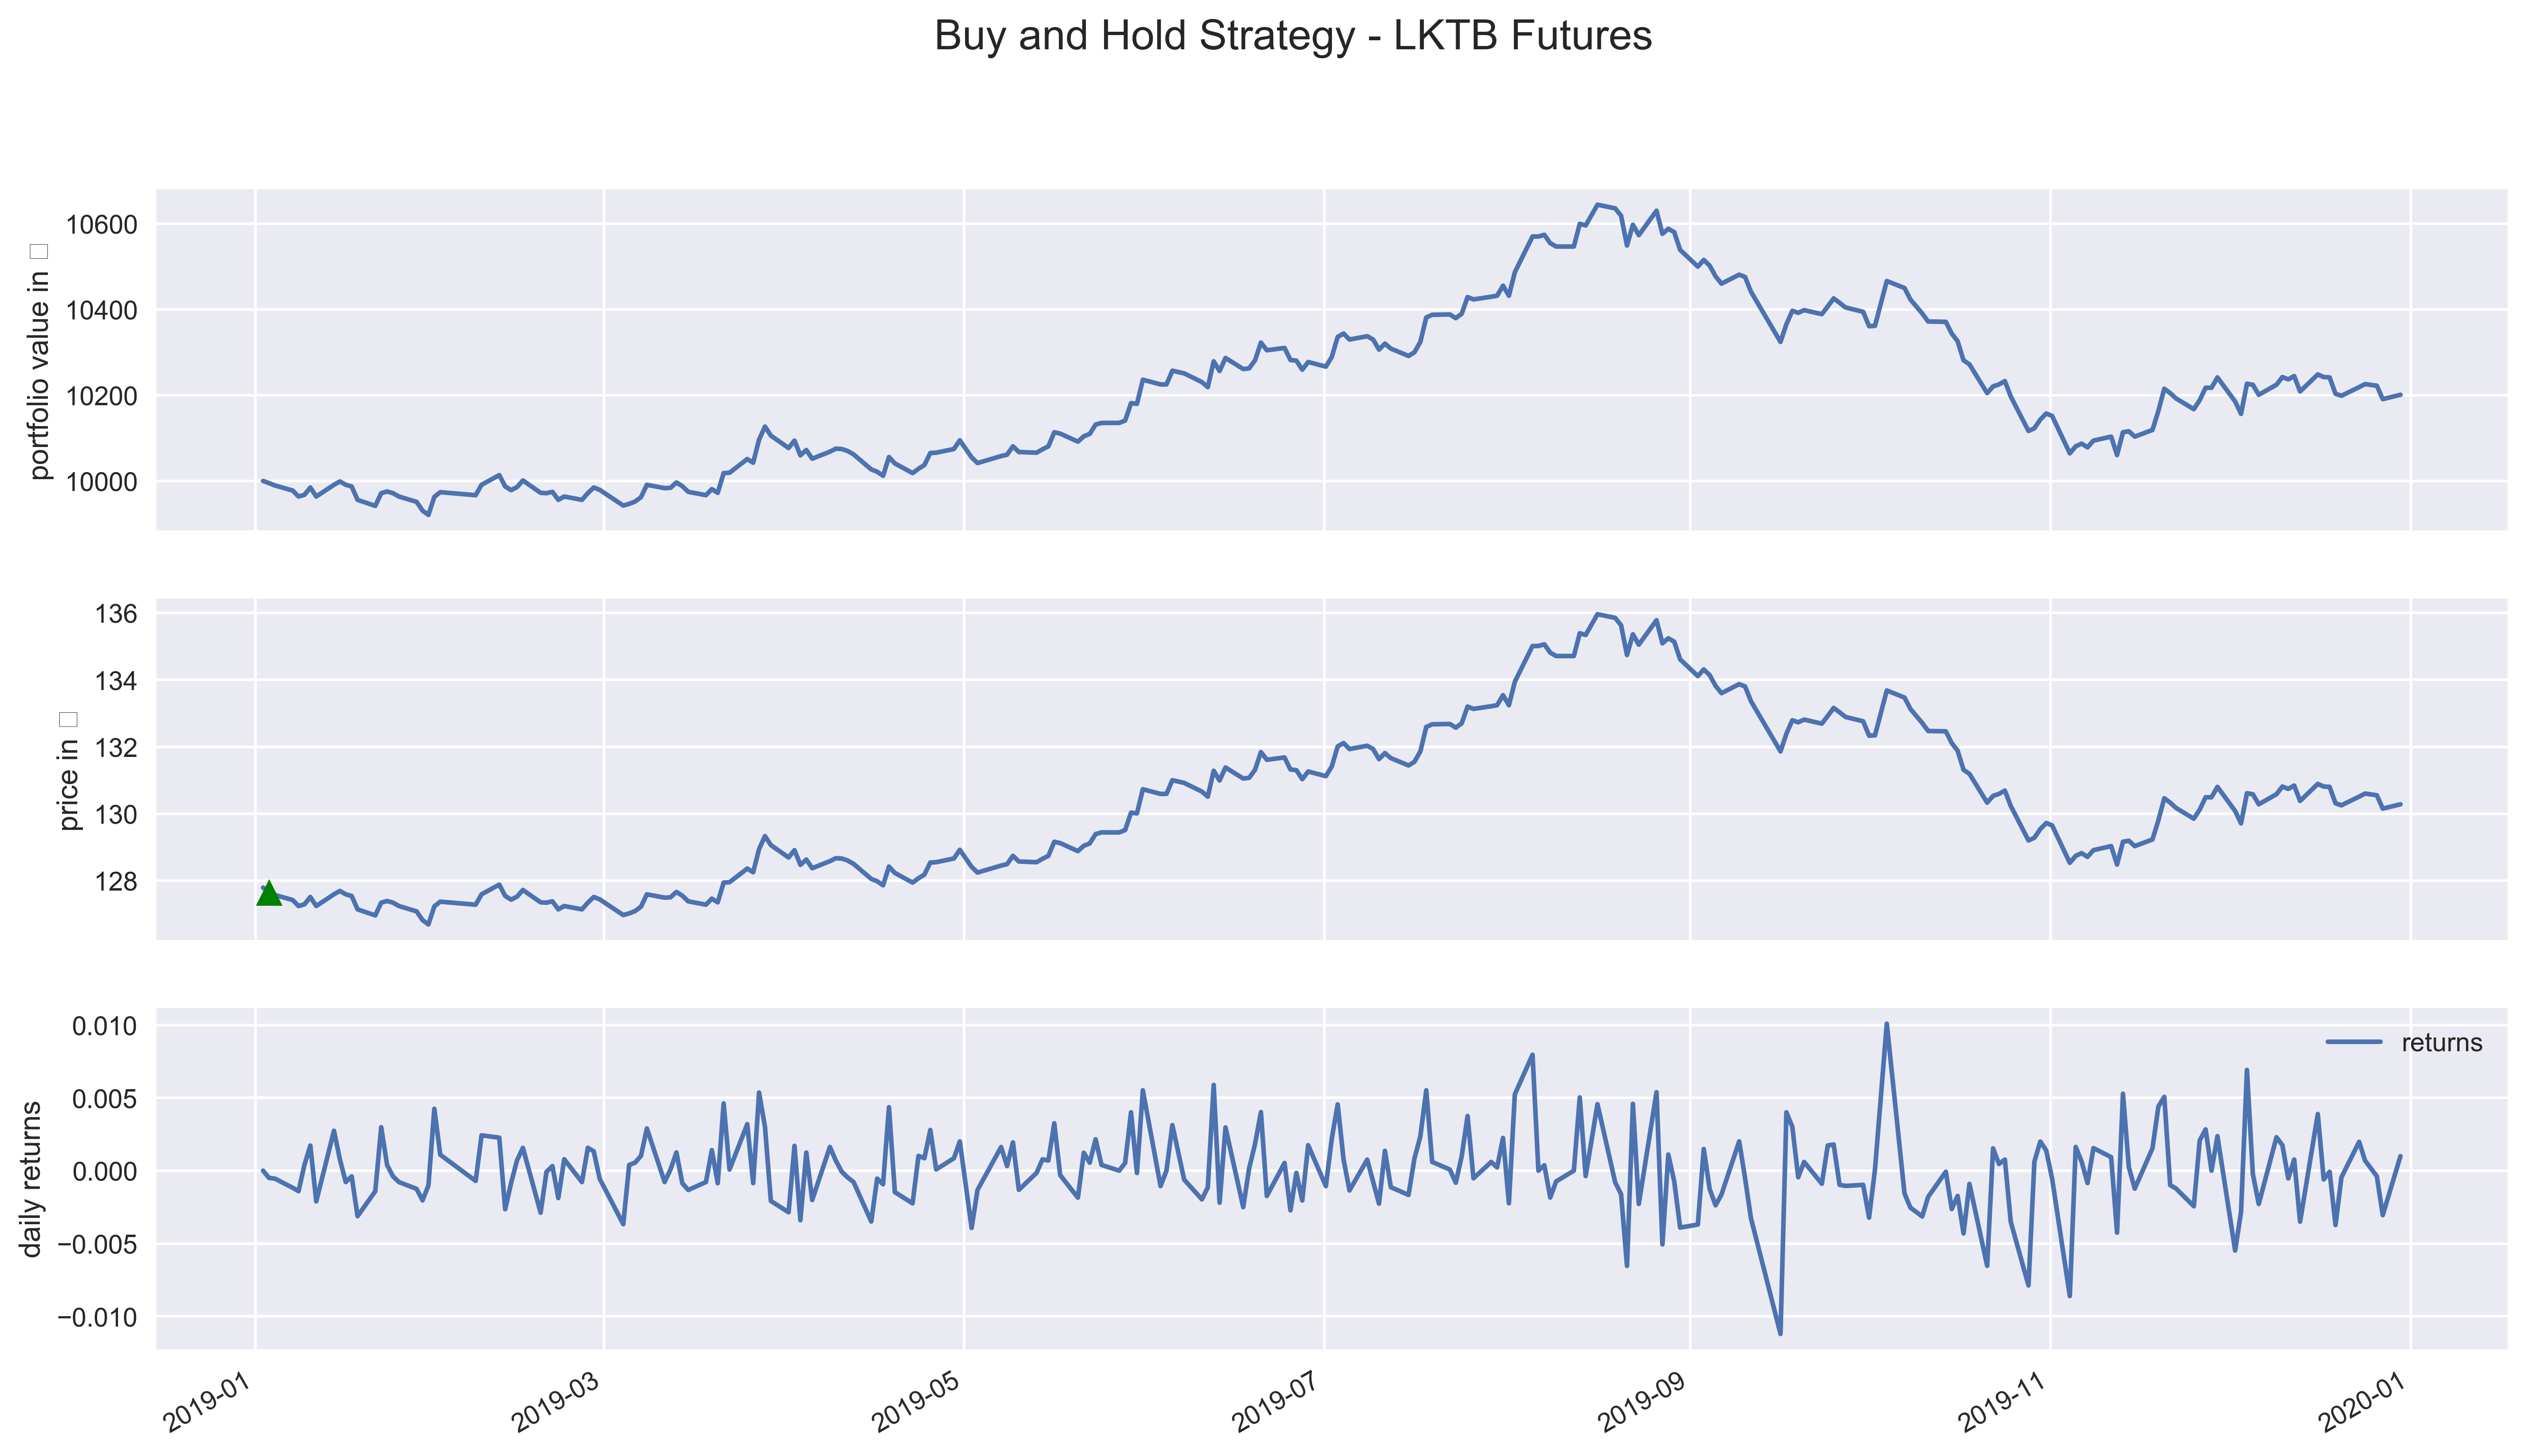

Final portfolio value (including cash): 10200.94￦


In [9]:
# import helper functions 
import qf_helper_functions as qf

qf.visualize_results(buy_and_hold_results, 'Buy and Hold Strategy - LKTB Futures', '￦')

Start date,2019-01-02
End date,2019-12-30
Total months,11
,Backtest
Annual return,2.1%
Cumulative returns,2.0%
Annual volatility,4.2%
Sharpe ratio,0.50
Calmar ratio,0.38
Stability,0.37
Max drawdown,-5.5%


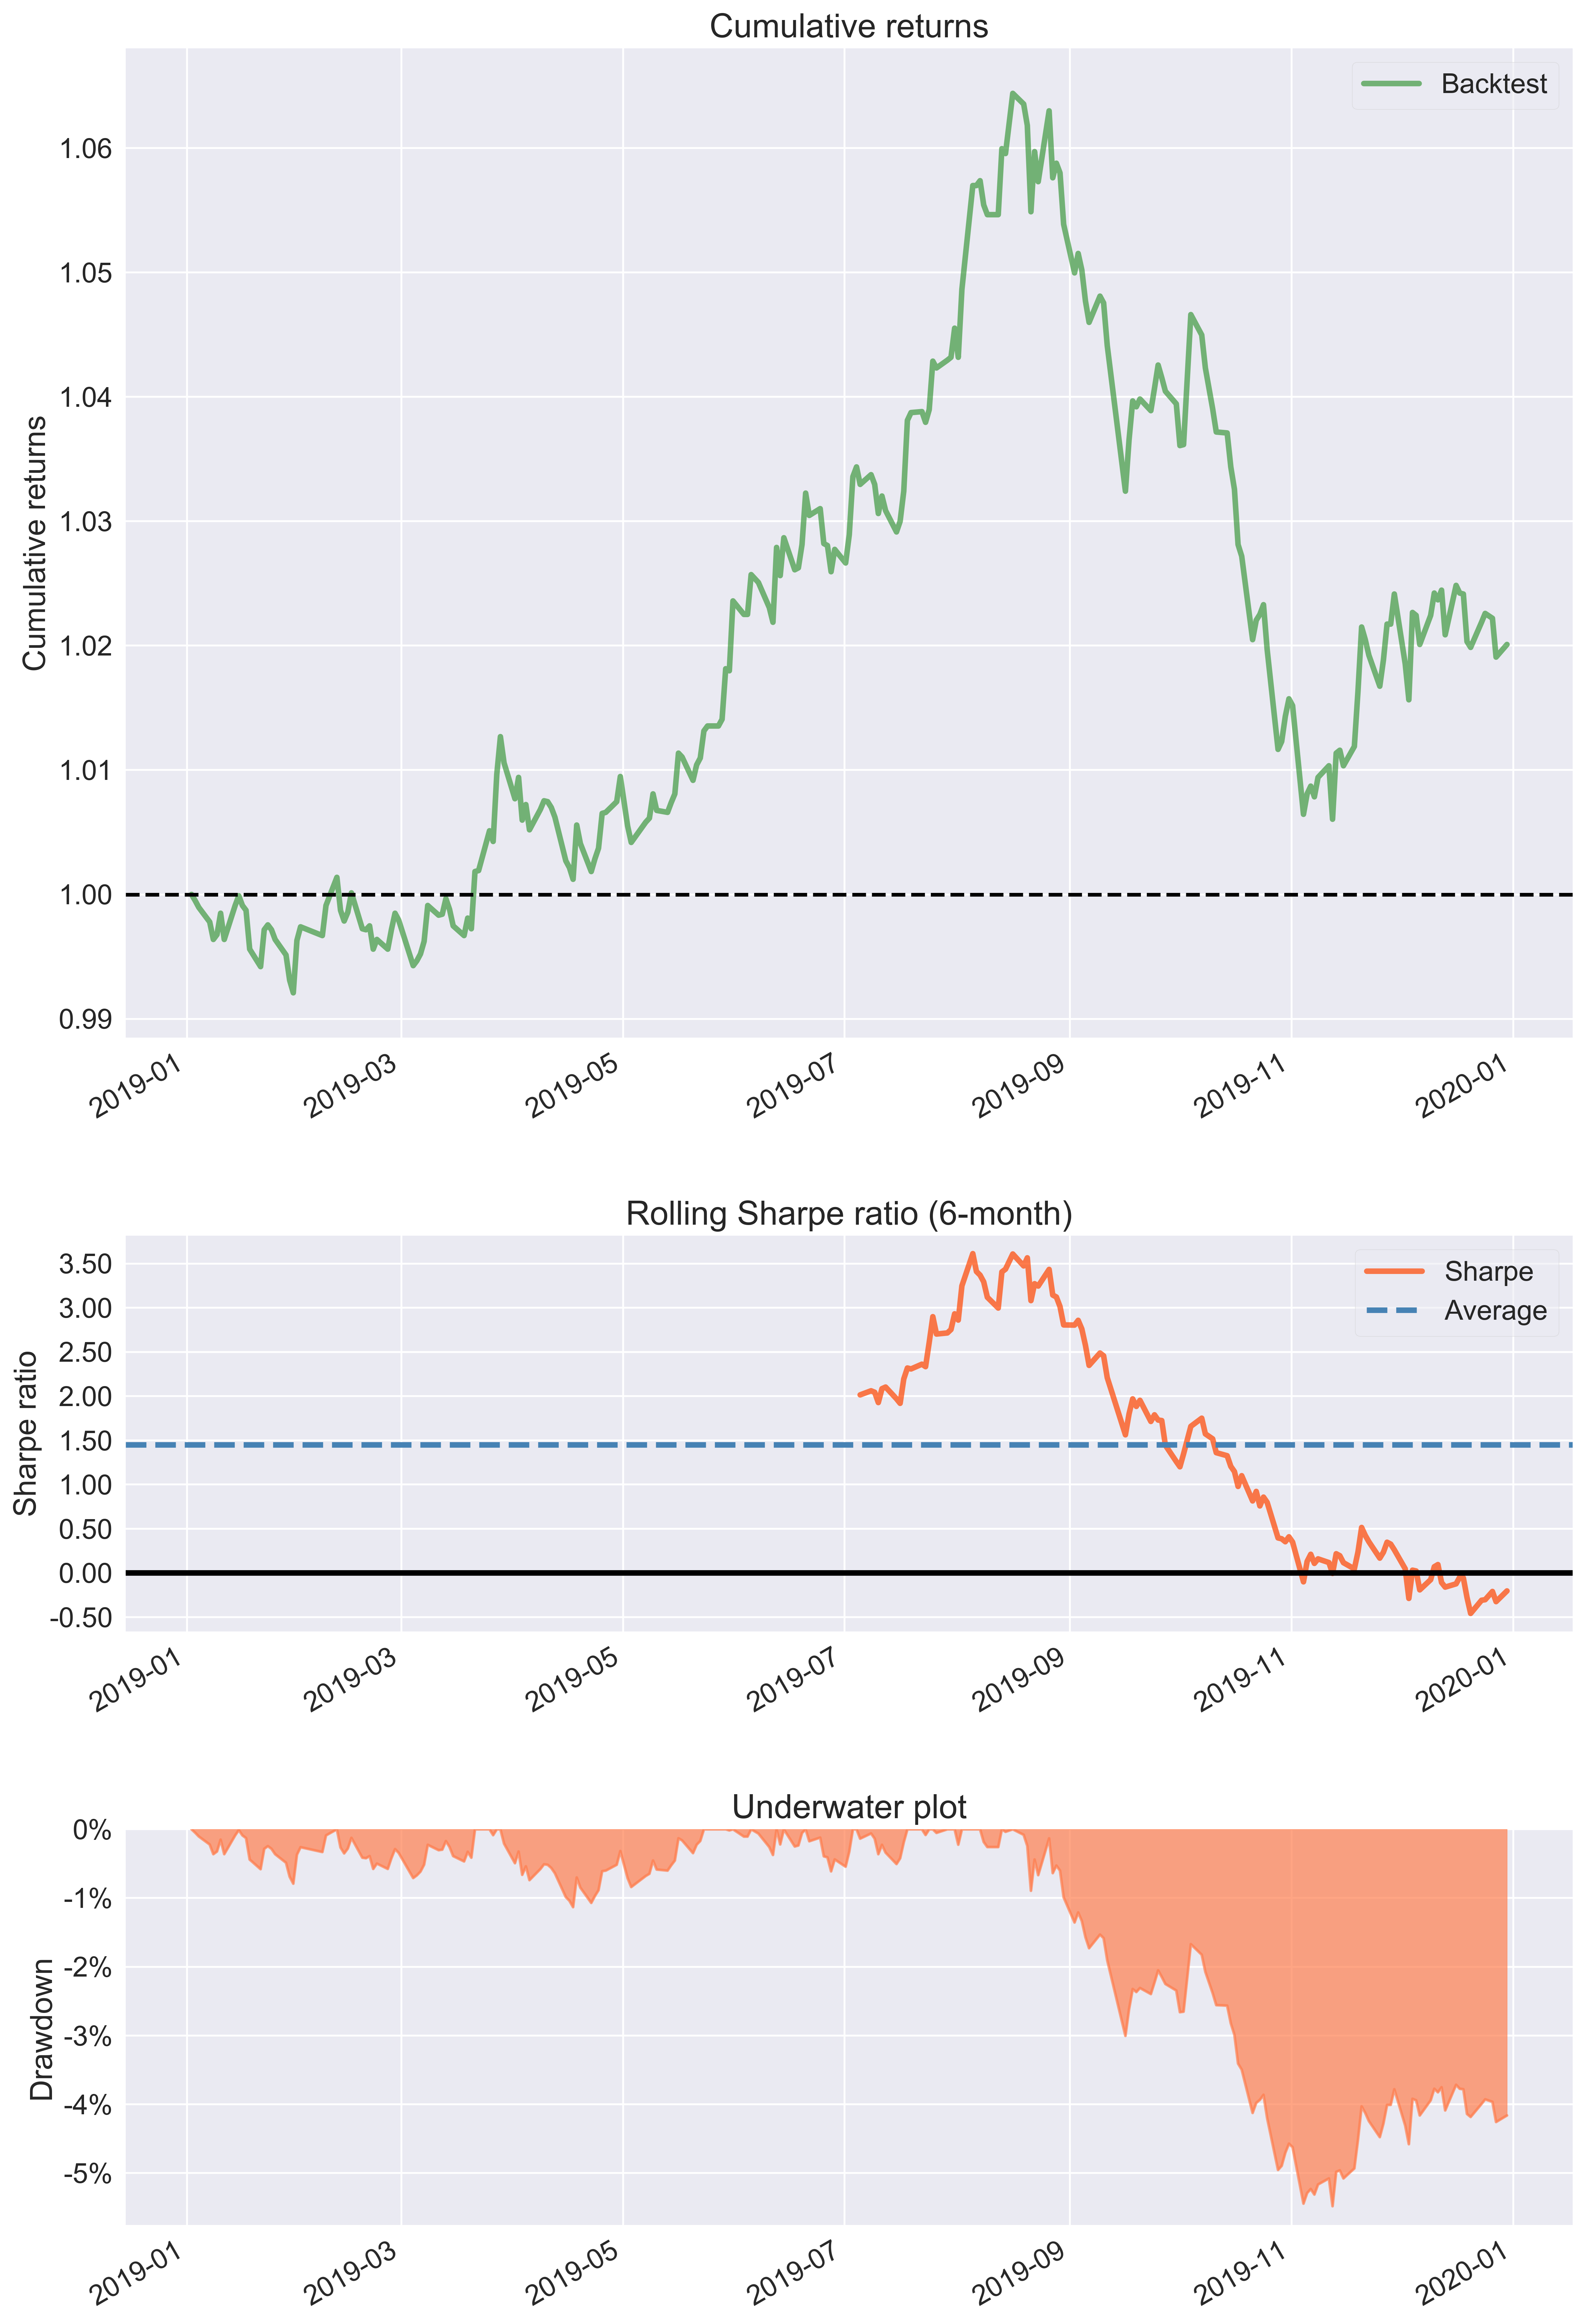

In [12]:
import pyfolio as pf

# possible additional summary statistics
pf.create_simple_tear_sheet(buy_and_hold_results.returns)

In [11]:
buy_and_hold_perf = qf.get_performance_summary(buy_and_hold_results.returns)

### Simple Moving Average Strategy

In [ ]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o simple_moving_average.pkl --trading-calendar XKRX

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
MA_PERIODS = 20
SELECTED_STOCK = 'LKTB'

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False

def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=MA_PERIODS, frequency="1d")
    ma = price_history.mean()
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)

In [ ]:
sma_results = pd.read_pickle('simple_moving_average.pkl')
qf.visualize_results(sma_results, 'Simple Moving Average Strategy - LKTB Futures', '￦')

In [ ]:
fig, ax = plt.subplots()

# asset
sma_results[['price', 'moving_average']].plot(ax=ax)
ax.set_ylabel('price in ￦')

# mark transactions
perf_trans = sma_results.loc[[t != [] for t in sma_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, sma_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, sma_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Simple Moving Average Strategy - LKTB Futures', fontsize=16)
plt.legend()
plt.show()

In [ ]:
sma_perf = qf.get_performance_summary(sma_results.returns)

In [ ]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o moving_average_crossover.pkl --trading-calendar XKRX

# imports 
from zipline.api import order_percent, record, symbol, order_target
from zipline.finance import commission

# parameters 
SELECTED_STOCK = 'LKTB'
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):

    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # Trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)

In [ ]:
mac_results = pd.read_pickle('moving_average_crossover.pkl')
qf.visualize_results(mac_results, 'Moving Average Crossover Strategy - LKTB Futures', '￦')

In [ ]:
fig, ax = plt.subplots()

# asset
mac_results[['price', 'fast_ma', 'slow_ma']].plot(ax=ax)
ax.set_ylabel('price in KRW')

# mark transactions
perf_trans = mac_results.loc[[t != [] for t in mac_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, mac_results.price.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, mac_results.price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('Moving Average Crossover Strategy - LKTB Futures', fontsize=16)
plt.legend()
plt.show()

In [ ]:
mac_perf = qf.get_performance_summary(mac_results.returns)

### MACD

In [ ]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o macd.pkl --trading-calendar XKRX

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'LKTB'

 #initialize the strategy 
def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=34, frequency="1d")
    macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
    
    if (macdsignal[-1] < macd[-1]) and (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
        
    if (macdsignal[-1] > macd[-1]) and (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False
        
    record(macd =  macd[-1], macdsignal = macdsignal[-1], macdhist = macdhist[-1], price=price_history[-1]) 

In [ ]:
macd_results = pd.read_pickle('macd.pkl')
qf.visualize_results(macd_results, 'MACD Strategy - LKTB Futures', '￦')

In [ ]:
fig, ax = plt.subplots()

# asset
macd_results[['macd', 'macdsignal']].plot(ax=ax)
ax.set_ylabel('price in ￦')

# mark transactions
perf_trans = macd_results.loc[[t != [] for t in macd_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, macd_results.macd.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, macd_results.macd.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('MACD Strategy - LKTB Futures', fontsize=16)
plt.show()

In [ ]:
macd_perf = qf.get_performance_summary(macd_results.returns)

### RSI

In [ ]:
%%zipline --start 2019-1-2 --end 2019-12-30 --capital-base 10000 --bundle krx_futures -o rsi.pkl --trading-calendar XKRX

# imports ----
from zipline.api import order_target, record, symbol, set_commission, order_percent
import matplotlib.pyplot as plt
import talib as ta
from zipline.finance import commission

# parameters ----
SELECTED_STOCK = 'LKTB'
UPPER = 70
LOWER = 30
RSI_PERIOD = 14

#initialize the strategy 
def initialize(context):
    context.asset = symbol(SELECTED_STOCK)
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.has_position = False
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=RSI_PERIOD+1, frequency="1d")
    rsi = ta.RSI(price_history, timeperiod=RSI_PERIOD)
    
    if rsi[-1] < LOWER and not context.has_position:
        order_percent(context.asset, 1.0)
        context.has_position = True
      
    if rsi[-1] > UPPER and context.has_position:
        order_target(context.asset, 0)
        context.has_position = False
     
    record(rsi=rsi[-1], price=price_history[-1]) 

In [ ]:
rsi_results = pd.read_pickle('rsi.pkl')
qf.visualize_results(rsi_results, 'RSI Strategy - LKTB Futures', '￦')

In [ ]:
#fig, ax = plt.subplots(1, 1, sharex=True, figsize=[16, 9])
fig, ax = plt.subplots()

# asset
rsi_results[['rsi']].plot(ax=ax)
ax.axhline(y=70, color='r')
ax.axhline(y=30, color='g')

# mark transactions
perf_trans = rsi_results.loc[[t != [] for t in rsi_results.transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
ax.plot(buys.index, rsi_results.rsi.loc[buys.index], '^', markersize=10, color='g', label='buy')
ax.plot(sells.index, rsi_results.rsi.loc[sells.index], 'v', markersize=10, color='r', label='sell')
ax.legend()

fig.suptitle('RSI Strategy - LKTB Futures', fontsize=16)
plt.show()

In [ ]:
rsi_perf = qf.get_performance_summary(rsi_results.returns)

## Evaluating the performance

In [ ]:
perf_df = pd.DataFrame({'Buy and Hold': buy_and_hold_perf,
                        'Simple Moving Average': sma_perf,
                        'Moving Average Crossover': mac_perf,
                        'MACD': macd_perf,
                        'RSI': rsi_perf})
perf_df.transpose()